# Prototype

## Introduction

This notebook contains the prototype in my attempt to make a mapping between the latent space of the Autoencoder and the word embeddings of a text generation RNN. In between those two networks, is the Mapper network.

In [85]:
%load_ext autoreload
%autoreload 2

In [101]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tensorflow import keras
from random import choices
from os import path, getcwd

In [55]:
from autoencoder import Autoencoder
from word2vec import build_model, make_ckpt_callback, generate_text
from utilities import split_input_target, interpolate, texts_to_ints

## Setup

The dataset consists of 2500 images and texts. The images are lines generated by a simple script. The points that are connected by the line map to a sequence of symbols. For example, point A (1, 1) maps to 'bb', which connects to point B (6, 4) 'ge'. The line drawing of points A and B, therefore, results in the sequence 'bbge'. Finally, every sequence is concatenated with a new line character in between. 

Note: The origin is in the lower-left corner. The images and sequences were generated using Drawbot.

In [90]:
root = path.join("..", "..")

# imgs and text are paired datasets, the order is important!
imgs = np.load(path.join(root, "data", "sets", "ll.npy"))
text = open(path.join(root, "data", "sets", "ll.txt"), 'rb').read().decode(encoding='utf-8')

# removing spaces, at first the seemed like a good idea, but it is less intuitive to analyze what is going on.
text = text.replace(' ', '')

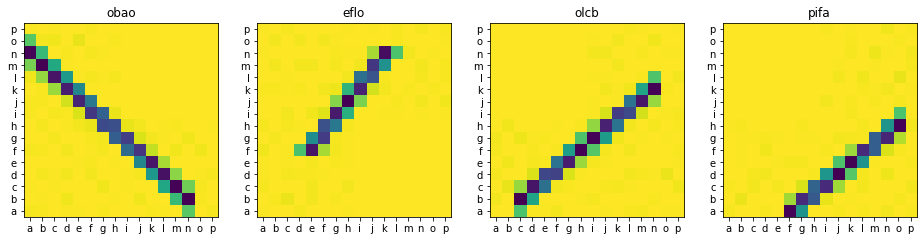

In [117]:
abc = [c for c in 'abcdefghijklmnopqrstuvwxyz'][:16]
titles = text.split('\n')

fig, axs = plt.subplots(1, 4, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i])
    ax.set_title(titles[i])

    ax.set_xticks(np.arange(len(abc)))
    ax.set_xticklabels(abc)

    ax.set_yticks(np.arange(len(abc))[::-1])
    ax.set_yticklabels(abc)

plt.show()

In [13]:
# -- Autoencoder globals
LATENT_DIM = 8
AE_EPOCHS = 300

# -- W2V globals
W2V_EPOCHS = 30

BATCH_SIZE = 64
BUFFER_SIZE = 10000

EMBEDDING_DIM = 256
RNN_UNITS = 1024

# -- MAPPER GLOBALS
MPPR_EPOCHS = 300

## Training

### AUTOENCODER

Its a straight forward autoencoder consisting of 3 hidden layers (64, 8, 64) with an input and output shape of (16,16). The full implementation can be found [here](https://github.com/maxvstheuniverse/thesis-explorations/tree/master/src/mapper/autoencoder.py).

In [14]:
normalized_imgs = imgs / 255.0   # normalize the pixel data to range of 0, 1 

In [15]:
autoencoder = Autoencoder(LATENT_DIM)
autoencoder.summarize()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 16,968
Trainable params: 16,968
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_7 (Dense)              (None, 256)               16640     
____________________________

In [16]:
autoencoder.train(normalized_imgs, AE_EPOCHS, verbose=0)

Trained 0300 epochs in 147.060s


Below are three rows. The first shows the original image, the second row the reconstructed image. The final row shows an interpolation between the first and last reconstructed image. The interpolation is not that relevant, but I always find it insightful to see how the interpolation behaves.

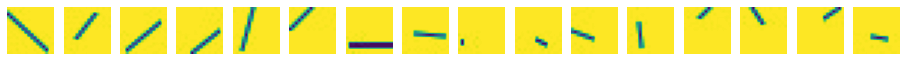

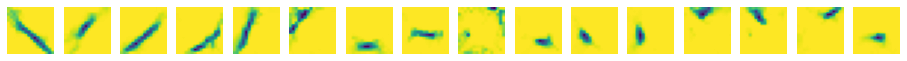

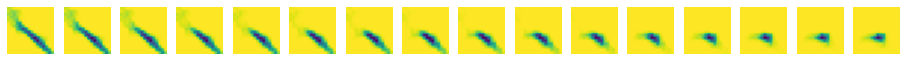

In [17]:
y_latent = autoencoder.encode(normalized_imgs[:16])
reconstruction = autoencoder.decode(y_latent, apply_sigmoid=True)

fig, axs = plt.subplots(1, 16, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(normalized_imgs[i])
    ax.axis("off")
    
fig, axs = plt.subplots(1, 16, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(reconstruction[i])
    ax.axis("off")

# -- Not really relevant, but still I find it always interesting to show the interpolation behaves.
interpolation = interpolate(y_latent[0], y_latent[-1], 16)
ims = autoencoder.decode(interpolation, apply_sigmoid=True)

fig, axs = plt.subplots(1, 16, figsize=(16, 16))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(ims[i])
    ax.axis("off")

### WORD2VEC

This word2vec is setup up to generate strings of symbols. Its main goal at this time is to create proper word embeddings. The results are gibberish, but words embeddings appear to work. I have tried several things to develop the word embeddings, but without connecting the text and the images everything the results were just too random. The implementation of the model can be found [here](https://github.com/maxvstheuniverse/thesis-explorations/tree/master/src/mapper/word2vec.py).

In [23]:
vocab = sorted(set(text))
vocab_size = len(vocab)
print ('{} unique characters'.format(vocab_size))

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = [char2idx[c] for c in text]

seq_length = 5
examples_per_epoch = len(text) // (seq_length + 1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(repr(idx2char[i.numpy()]))

sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

18 unique characters
'o'
'b'
'a'
'o'
'\n'


In [27]:
dataset = sequences.map(split_input_target)

for input_example, target_example in dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

Input data:  'obao\n'
Target data: 'bao\ne'


<BatchDataset shapes: ((64, 5), (64, 5)), types: (tf.int32, tf.int32)>

In [33]:
w2v_ckpt_dir = './checkpoints/w2v'

w2v = build_model(vocab_size, EMBEDDING_DIM, RNN_UNITS, batch_size=BATCH_SIZE)
w2v.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (64, None, 256)           4608      
_________________________________________________________________
gru_5 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_13 (Dense)             (64, None, 18)            18450     
Total params: 3,961,362
Trainable params: 3,961,362
Non-trainable params: 0
_________________________________________________________________


In [86]:
w2v.fit(dataset, epochs=W2V_EPOCHS, callbacks=[make_ckpt_callback(w2v_ckpt_dir)], verbose=0)

In [35]:
# after training, recreate the model.
# to generate text it is required to change the batchsize to 1.
recreated_word2vec = build_model(vocab_size, EMBEDDING_DIM, RNN_UNITS, batch_size=1)

recreated_word2vec.load_weights(tf.train.latest_checkpoint(w2v_ckpt_dir))
recreated_word2vec.build(tf.TensorShape([1, None]))
recreated_word2vec.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (1, None, 256)            4608      
_________________________________________________________________
gru_6 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_14 (Dense)             (1, None, 18)             18450     
Total params: 3,961,362
Trainable params: 3,961,362
Non-trainable params: 0
_________________________________________________________________


In [45]:
# this is all gibberish. :)
print(regenerate_text(recreated_word2vec, char2idx, idx2char, start_string=u"m"))

m
an
ljco
eel
mlmjdl
laco
lnqi
kik
oin
fo
gkd
gmpf
bfo
blihf
jmod
oflh
jlmj
elahoj
hlqo
qahl
kliqo
mo


### MAPPER

Below is the Mapper Network, it reuses the word embeddings of the RNN above. The network takes the symbols of each image as the input and the latent variables of that image as the target. An important part is that the Embedding layer is not trainable to preserve the word embeddings found by the RNN.

In [46]:
# Get the embedding weights from the recreated word2vec model
embedding_layer = recreated_word2vec.layers[0]
mapper_ckpt_dir = './checkpoints/mapper'

mapper = keras.Sequential([
    keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(8)
])

# This ensures that the weights in the embedding are preserved.
# Then load the weights from the word2vec embedding layer.
mapper.layers[0].trainable = False
mapper.layers[0].set_weights(embedding_layer.get_weights())

mapper.compile(loss="mse", optimizer="adam")
mapper.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 256)         4608      
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 520       
Total params: 21,576
Trainable params: 16,968
Non-trainable params: 4,608
_________________________________________________________________


In [48]:
# 'y' are latent variables, which correspond to 'x', which are the words as ints.
mapper_y = autoencoder.encode(imgs)  
mapper_x = np.array([[char2idx[c] for c in word] for word in text.split('\n')])

In [118]:
# a check if that is really the case.
assert mapper.layers[0].trainable == False

# train the mapping model
mapper.fit(mapper_x, mapper_y, epochs=MPPR_EPOCHS, callbacks=[make_ckpt_callback(mapper_ckpt_dir)])

It following cell the first 8 words are encoded and decoded. The comparison doesn't really show any that much similarities with the original. I suspected this to be the case. As the semantics are connected to points in space, the start and the end of the line, and not to the line itself. The points themselvers are also not clearly visible. The next step would be to see how similar strings map to a space.

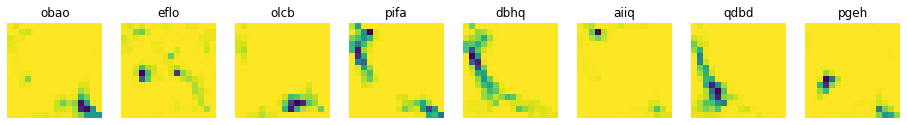

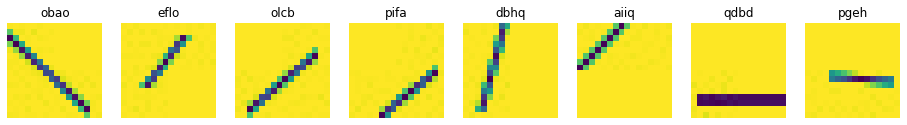

In [52]:
latent_vars = mapper.predict(mapper_x[:8])
reconstruction = autoencoder.decode(latent_vars, apply_sigmoid=True)
words = text.split('\n')[:8]

fig, axs = plt.subplots(1, 8, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    ax.set_title(words[i])
    ax.imshow(reconstruction[i])
    ax.axis("off")

fig, axs = plt.subplots(1, 8, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    ax.set_title(words[i])
    ax.imshow(imgs[i])
    ax.axis("off")

## Mapping Analogies

It appears, the some words map to very similar images. However, certain analogies also appear to be very different, such as the `amma` and `ommo` pair. If looking from the perspective of the mappings that I created this may be a correct results, as `a` and `o` are quite far apart in space.

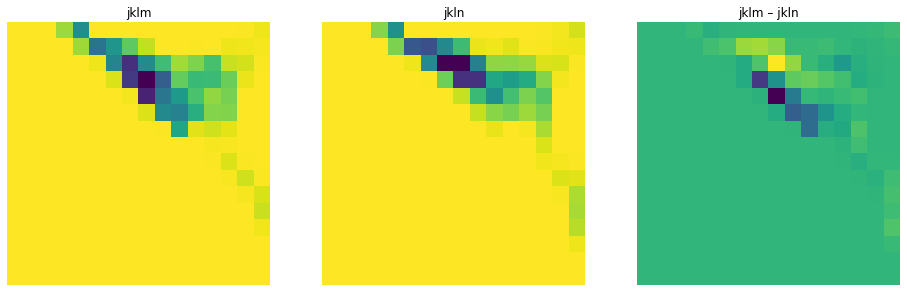

In [71]:
t_analogies = ['jklm', 'jkln']                                      # text
l_analogies = mapper.predict(texts_to_ints(t_analogies, char2idx))  # latent
r_analogies = autoencoder.decode(l_analogies, apply_sigmoid=True)   # reconstructed

fig, axs = plt.subplots(1, 3, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    if i == 2:
        ax.set_title(f"{t_analogies[i-2]} – {t_analogies[i-1]}")
        ax.imshow(r_analogies[i-2] - r_analogies[i-1])
    else:
        ax.set_title(t_analogies[i])
        ax.imshow(r_analogies[i])
    ax.axis("off")

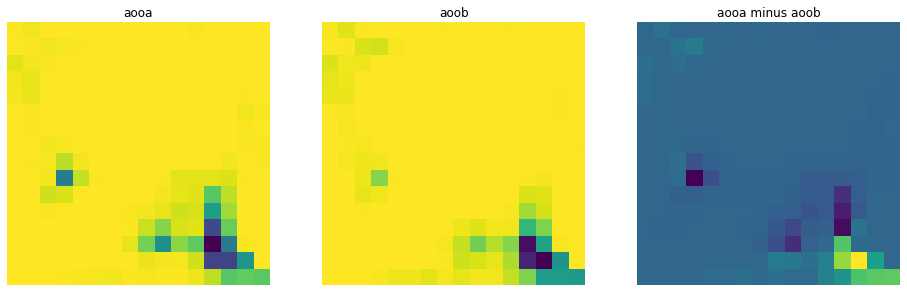

In [67]:
t_analogies = ['aooa', 'aoob']                                      # text
l_analogies = mapper.predict(texts_to_ints(t_analogies, char2idx))  # latent
r_analogies = autoencoder.decode(l_analogies, apply_sigmoid=True)   # reconstructed

fig, axs = plt.subplots(1, 3, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    if i == 2:
        ax.set_title(f"{t_analogies[i-2]} – {t_analogies[i-1]}")
        ax.imshow(r_analogies[i-2] - r_analogies[i-1])
    else:
        ax.set_title(t_analogies[i])
        ax.imshow(r_analogies[i])
    ax.axis("off")

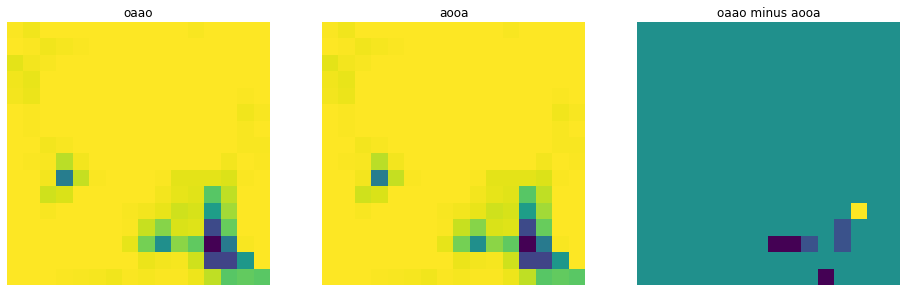

In [65]:
t_analogies = ['oaao', 'aooa']                                      # text
l_analogies = mapper.predict(texts_to_ints(t_analogies, char2idx))  # latent
r_analogies = autoencoder.decode(l_analogies, apply_sigmoid=True)   # reconstructed

fig, axs = plt.subplots(1, 3, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    if i == 2:
        ax.set_title(f"{t_analogies[i-2]} – {t_analogies[i-1]}")
        ax.imshow(r_analogies[i-2] - r_analogies[i-1])
    else:
        ax.set_title(t_analogies[i])
        ax.imshow(r_analogies[i])
    ax.axis("off")

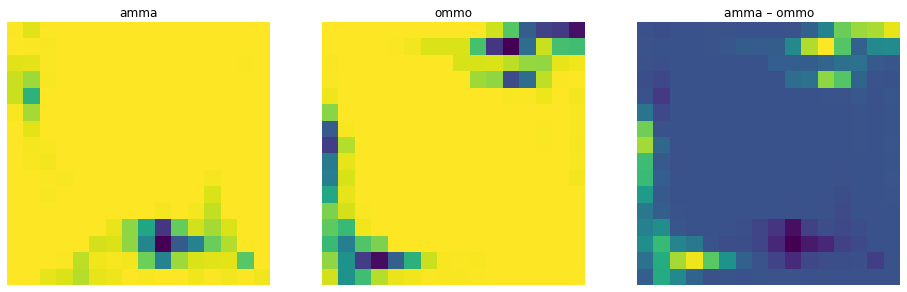

In [76]:
t_analogies = ['amma', 'ommo']                                      # text
l_analogies = mapper.predict(texts_to_ints(t_analogies, char2idx))  # latent
r_analogies = autoencoder.decode(l_analogies, apply_sigmoid=True)   # reconstructed

fig, axs = plt.subplots(1, 3, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    if i == 2:
        ax.set_title(f"{t_analogies[i-2]} – {t_analogies[i-1]}")
        ax.imshow(r_analogies[i-2] - r_analogies[i-1])
    else:
        ax.set_title(t_analogies[i])
        ax.imshow(r_analogies[i])
    ax.axis("off")

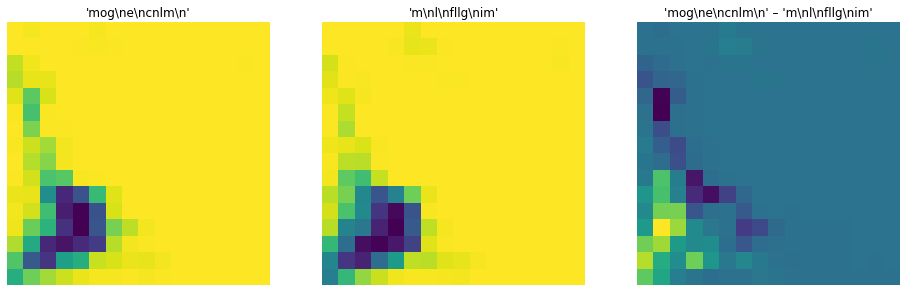

In [83]:
a = generate_text(recreated_word2vec, char2idx, idx2char, start_string=u"m", num_generate=10)
b = generate_text(recreated_word2vec, char2idx, idx2char, start_string=u"m", num_generate=10)

t_analogies = [a, b]                                                 # text
l_analogies = mapper.predict(texts_to_ints(t_analogies, char2idx))   # latent
r_analogies = autoencoder.decode(l_analogies, apply_sigmoid=True)    # reconstructed

fig, axs = plt.subplots(1, 3, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    if i == 2:
        ax.set_title(f"{repr(t_analogies[i-2])} – {repr(t_analogies[i-1])}")
        ax.imshow(r_analogies[i-2] - r_analogies[i-1])
    else:
        ax.set_title(repr(t_analogies[i]))
        ax.imshow(r_analogies[i])
    ax.axis("off")

## Discussion

In the original Line Language Autoencoder, I used a dataset of 5000 samples. This time, to save me some time, I used only 2500, in the autoencoder results, this is visible. A more extensive dataset will improve the results. Additionally, using Convolutional Variational Autoencoder could be worth checking out. This interpolates better, between to points in the latent space. I’m not sure if that is desired as interpolation is not what we are after.

After trying several things without building a relation between the images and the texts. I found that this might be the only way to go. By making a connection between the two, I’m building upon the assumption, that the language is always present in the population, and provides the ability that you can imagine something that you have never seen, if someone else would describe it to you. What this also means is that you can learn something without mimesis. (I’m looking further into this assumption, hope give a better explanation soon)

Currently, all sequences of symbols are concatenated. The pairs are shuffled, but that means that two symbols are randomly connected, which will be captured in the embedding. Although being separated by a newline character, it appears that the original relation between text and image is lost. This might be a good thing.

The pipeline from artefact to word still needs to be built.

My idea was to develop a real-time simulation, but I’m starting to doubt if that is possible with these techniques. This was one of the main reasons why an autoencoder could be an analogy machine as it would generate a new artefact based only on what it has seen before.

One approach to real-time training would be to use a dynamic loss function, which records all the gradients. Taking the last `n` gradients and weight them, so the new examples have more effect. Then with every sample apply those weighted gradients. By using this sliding window, the networks would then adapt over time. 

Perhaps it is good to start thinking of alternative ways to apply this prototype in social creativity simulations.